# Retail Store Demand Forecasting

Objective  
Explore historical retail store data and check how past sales and promotion signals relate to demand one week ahead.

Hypotheses  

- **Null hypothesis (H₀)**: Past sales and promotions do not add significant predictive signal for next week product demand.  
- **Alternative hypothesis (Hₐ)**: Past sales and promotions add significant predictive signal for next week product demand.


## 1. Setup and data loading


In [18]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

plt.style.use("default")

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

In [19]:
# Load dataset
csv_path = (
    "data/retail_store_inventory.csv"  # place notebook and CSV in the same folder
)
df = pd.read_csv(csv_path)

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,28.46,20,Sunny,1,29.40,Winter


## 2. Data overview and basic cleaning


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 7.8+ MB


In [21]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Date,73100,731,2022-01-01,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Store ID,73100,5,S001,14620,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Product ID,73100,20,P0001,3655,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,73100,5,Furniture,14699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Region,73100,4,East,18349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Inventory Level,73100.0,NaN,NaN,NaN,274.469877,129.949514,50.0,162.0,273.0,387.0,500.0
Units Sold,73100.0,NaN,NaN,NaN,136.46487,108.919406,0.0,49.0,107.0,203.0,499.0
Units Ordered,73100.0,NaN,NaN,NaN,110.004473,52.277448,20.0,65.0,110.0,155.0,200.0
Price,73100.0,NaN,NaN,NaN,55.135108,26.021945,10.0,32.65,55.05,77.86,100.0
Discount,73100.0,NaN,NaN,NaN,10.009508,7.083746,0.0,5.0,10.0,15.0,20.0


### 2.1 Column description

Short summary of main columns from this dataset.

- `Date`: Calendar date for the record.  
- `Store ID`: Store identifier.  
- `Product ID`: Product identifier.  
- `Category`: Product category.  
- `Region`: Store region.  
- `Inventory Level`: Stock level for that row.  
- `Units Sold`: Actual units sold on that date.  
- `Units Ordered`: Units placed on order.  
- `Demand Forecast`: Forecast quantity available in the raw data.  
- `Price`: Product price.  
- `Discount`: Discount percentage for that day.  
- `Weather Condition`: Weather label for that day.  
- `Holiday/Promotion`: Flag that marks holiday or promotion.  
- `Competitor Pricing`: Competitor price for the same product.  
- `Seasonality`: Season label.


### 2.2 Convert date column and check missing values


In [22]:
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")

missing_summary = df.isna().mean().sort_values(ascending=False)
missing_summary

Date                  0.0
Store ID              0.0
Product ID            0.0
Category              0.0
Region                0.0
Inventory Level       0.0
Units Sold            0.0
Units Ordered         0.0
Price                 0.0
Discount              0.0
Weather Condition     0.0
Holiday/Promotion     0.0
Competitor Pricing    0.0
Seasonality           0.0
dtype: float64

In [23]:
# Drop rows with missing Date or Units Sold, since those fields are central for this analysis
df = df.dropna(subset=["Date", "Units Sold"]).copy()

df.sort_values(["Store ID", "Product ID", "Date"], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-02,S001,P0001,Groceries,West,116,81,104,27.95,10,Cloudy,0,30.89,Spring
2,2022-01-03,S001,P0001,Electronics,West,154,5,189,62.70,20,Rainy,0,58.22,Winter
3,2022-01-04,S001,P0001,Groceries,South,85,58,193,77.88,15,Cloudy,1,75.99,Winter
4,2022-01-05,S001,P0001,Groceries,South,238,147,37,28.46,20,Sunny,1,29.40,Winter


## 3. Missing values ratio


In [24]:
missing_ratio = df.isna().sum().sort_values(ascending=False) / len(df) * 100
missing_ratio_df = missing_ratio.reset_index()
missing_ratio_df.columns = ["Column", "Missing_Ratio_percent"]
missing_ratio_df

,Column,Missing_Ratio_percent
0,Date,0.0
1,Store ID,0.0
2,Product ID,0.0
3,Category,0.0
4,Region,0.0
5,Inventory Level,0.0
6,Units Sold,0.0
7,Units Ordered,0.0
8,Price,0.0
9,Discount,0.0


The table shows the percentage of missing values per column.  
Every column has 0 percent missing values, so no imputation or row dropping is needed based on missingness.


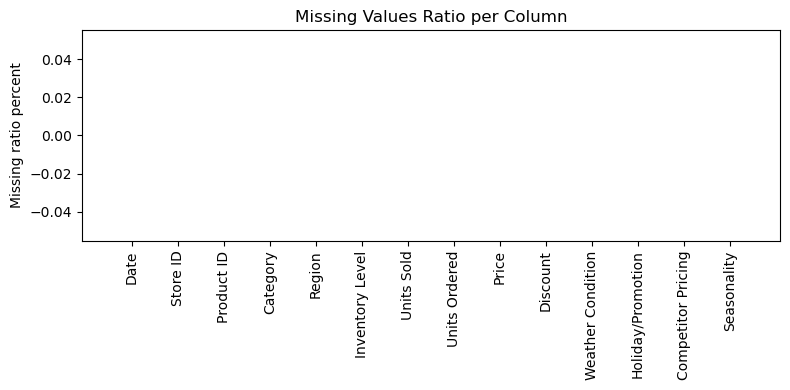

In [25]:
plt.figure(figsize=(8, 4))
plt.bar(missing_ratio_df["Column"], missing_ratio_df["Missing_Ratio_percent"])
plt.xticks(rotation=90)
plt.ylabel("Missing ratio percent")
plt.title("Missing Values Ratio per Column")
plt.tight_layout()
plt.show()

The bar plot confirms visually that all features have complete data.  
This simplifies further preprocessing because we do not need to handle missing values.


## 4. Low variance filter


In [26]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols

['Inventory Level',
 'Units Sold',
 'Units Ordered',
 'Price',
 'Discount',
 'Holiday/Promotion',
 'Competitor Pricing']

The list above shows all numeric variables that will be checked for low variance.


In [27]:
variance = df[numeric_cols].var().sort_values()
variance_df = variance.reset_index()
variance_df.columns = ["Numeric_Column", "Variance"]
variance_df

,Numeric_Column,Variance
0,Holiday/Promotion,0.249996
1,Discount,50.179461
2,Price,677.141602
3,Competitor Pricing,685.989846
4,Units Ordered,2732.931607
5,Units Sold,11863.437048
6,Inventory Level,16886.876218


The table reports variance for each numeric feature.

- `Holiday/Promotion` has variance around 0.25.  
- For a binary 0/1 variable this is actually the maximum possible variance and indicates a balanced flag.  
- Other variables have larger variance because they measure quantities or prices on continuous scales.

With a typical low variance filter threshold (for example zero or a very small value), no numeric feature would be removed.


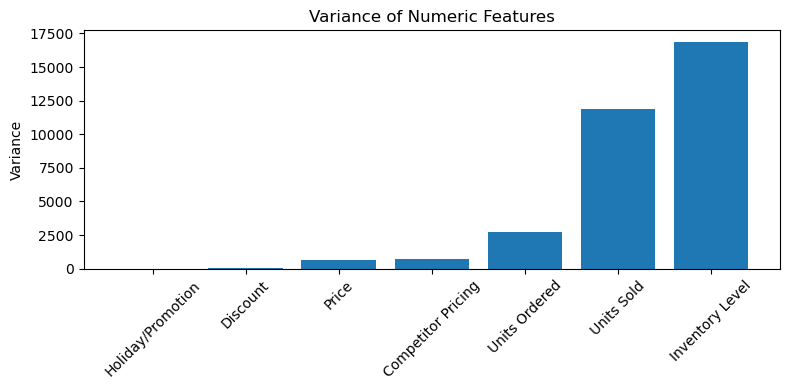

In [28]:
plt.figure(figsize=(8, 4))
plt.bar(variance_df["Numeric_Column"], variance_df["Variance"])
plt.xticks(rotation=45)
plt.ylabel("Variance")
plt.title("Variance of Numeric Features")
plt.tight_layout()
plt.show()

The bar chart highlights that `Inventory Level`, `Units Sold`, and `Units Ordered` have the largest spread,  
while `Holiday/Promotion` and `Discount` vary in a narrower numeric range.

Even so, no column is near zero variance, so all numeric features are kept after this step.


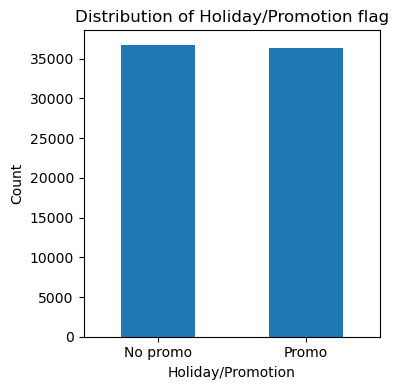

In [29]:
plt.figure(figsize=(4, 4))
df["Holiday/Promotion"].value_counts().sort_index().plot(kind="bar")
plt.xticks([0, 1], ["No promo", "Promo"], rotation=0)
plt.ylabel("Count")
plt.title("Distribution of Holiday/Promotion flag")
plt.tight_layout()
plt.show()

The counts for `No promo` and `Promo` are similar.  
This confirms that the promotion flag is balanced and carries information rather than being dominated by a single value.


## 5. High correlation filter


In [30]:
corr_matrix = df[numeric_cols].corr()
corr_matrix

,Inventory Level,Units Sold,Units Ordered,Price,Discount,Holiday/Promotion,Competitor Pricing
Inventory Level,1.000000,0.589995,0.001060,0.009140,0.004889,0.003411,0.009365
Units Sold,0.589995,1.000000,-0.000930,0.001082,0.002576,-0.000374,0.001259
Units Ordered,0.001060,-0.000930,1.000000,0.004212,-0.000938,0.005446,0.004596
Price,0.009140,0.001082,0.004212,1.000000,0.001509,0.002309,0.993900
Discount,0.004889,0.002576,-0.000938,0.001509,1.000000,-0.000852,0.001958
Holiday/Promotion,0.003411,-0.000374,0.005446,0.002309,-0.000852,1.000000,0.001890
Competitor Pricing,0.009365,0.001259,0.004596,0.993900,0.001958,0.001890,1.000000


The table shows Pearson correlation coefficients between numeric features.  
Notice that the correlation between `Price` and `Competitor Pricing` is very close to 1, while most other pairs have much smaller values.


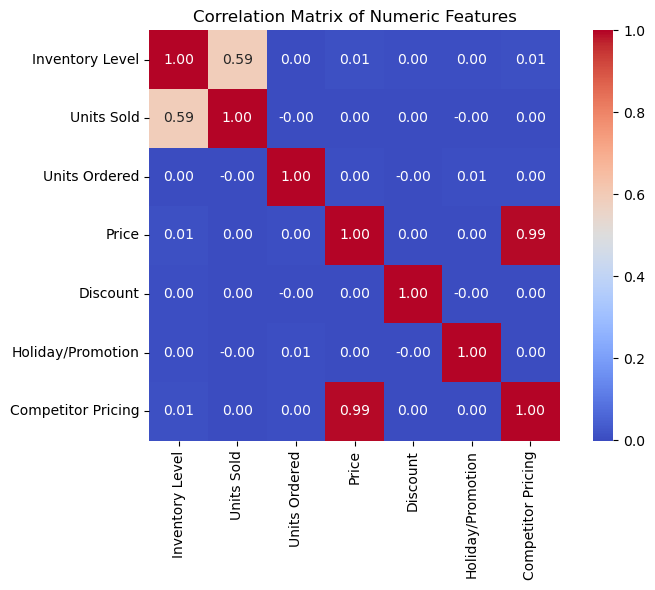

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

The heatmap makes strong relationships easy to see.  
The cell linking `Price` and `Competitor Pricing` stands out as dark red with value near 1.00,  
indicating a very strong positive linear relationship between these two features.


In [32]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper.stack().reset_index()
high_corr_pairs.columns = ["Feature_1", "Feature_2", "Correlation"]
high_corr_pairs = high_corr_pairs[high_corr_pairs["Correlation"].abs() > 0.9]
high_corr_pairs

,Feature_1,Feature_2,Correlation
17,Price,Competitor Pricing,0.9939


Only one pair crosses the absolute correlation threshold of 0.9:

- `Price` and `Competitor Pricing` with correlation around 0.99.

This means these two variables carry very similar information for most models,  
and at least one of them can be removed to reduce redundancy and multicollinearity.


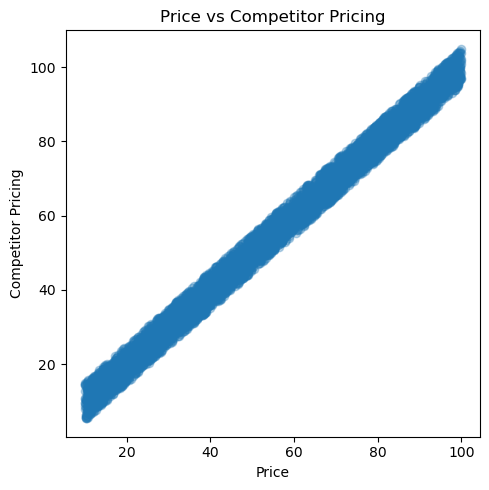

In [33]:
plt.figure(figsize=(5, 5))
sample = df.sample(min(5000, len(df)), random_state=42)
plt.scatter(sample["Price"], sample["Competitor Pricing"], alpha=0.3)
plt.xlabel("Price")
plt.ylabel("Competitor Pricing")
plt.title("Price vs Competitor Pricing")
plt.tight_layout()
plt.show()

The scatter plot shows that almost all points lie near a straight line.  
This visually confirms the strong linear relationship between `Price` and `Competitor Pricing` highlighted by the correlation matrix.


## 6. Findings for Missing Values Ratio, Low Variance Filter, High Correlation Filter


**Missing values ratio**  
- All columns have 0 percent missing values.  
- No variables are removed or imputed based on missingness.

**Low variance filter**  
- Every numeric feature shows non trivial variance.  
- `Holiday/Promotion` is a balanced binary flag with maximum possible variance for a 0/1 variable.  
- No numeric feature is dropped by a standard low variance threshold.

**High correlation filter**  
- Only one highly correlated pair is detected: `Price` and `Competitor Pricing` (correlation ≈ 0.99).  
- To avoid redundancy and multicollinearity, drop one of these two features in the modeling stage  
  (for example, keep `Price` and remove `Competitor Pricing`).

These results prepare a cleaner feature set for downstream modeling of demand and promotion effects.
